In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import tree

In [2]:
#run if pulling from git, ow ignore
import os
os.chdir('../') 
os.getcwd()

'/Volumes/T7/DATA422_Fall2024_Team5'

## create PC

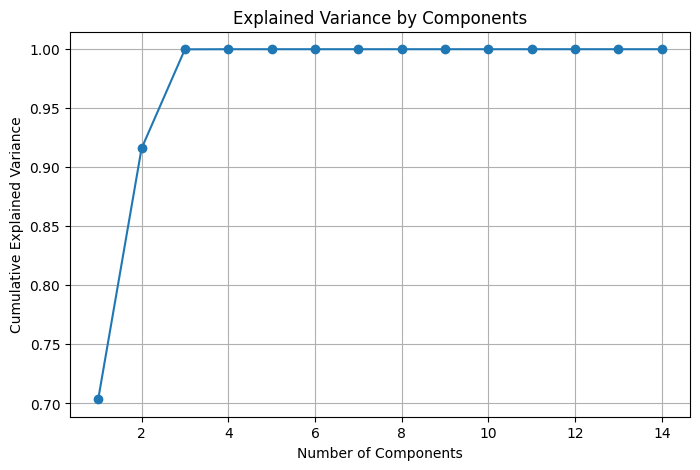

                             PC1           PC2           PC3           PC4  \
DataYear           -1.411477e-21 -1.420984e-20 -2.180115e-20 -1.642897e-19   
ZipCode            -8.639383e-08 -1.611543e-07  4.012432e-07 -1.548946e-05   
Latitude           -2.045064e-10 -1.632867e-10  2.719770e-10 -2.471850e-08   
Longitude           1.260943e-10  2.516549e-12  5.819919e-11 -1.136406e-08   
YearBuilt           3.033203e-07  1.143705e-07 -1.437313e-06  6.236555e-05   
NumberofFloors      3.307039e-07  1.709374e-07 -8.768887e-07  2.459107e-05   
NumberofBuildings   2.374985e-08  1.496275e-08  1.496271e-08 -6.971422e-08   
PropertyGFATotal    1.690465e-02  3.497863e-03 -2.271905e-02  9.995928e-01   
ENERGYSTARScore    -1.847940e-07 -5.977428e-07 -7.316101e-07  6.109785e-05   
SiteEUI(kBtu/sf)    1.663517e-06  1.983419e-06  2.037237e-06 -1.314110e-04   
SourceEUI(kBtu/sf)  3.518425e-06  2.171430e-06 -1.264619e-06 -3.590190e-04   
SteamUse(kBtu)      4.016437e-01 -5.676312e-01  7.185710e-01  1.

In [3]:
data = pd.read_csv('Data/Seattle_Building_Clusters.csv')
data = data.drop(columns=['OSEBuildingID','BuildingName', 'BuildingType', 'Address', 'Neighborhood', 'EPAPropertyType', 'ComplianceStatus', 'ComplianceIssue', 'GHGEmissionsIntensity'])
data = data.dropna()
cluster_col = data['GHGIntensityCluster'].reset_index(drop=True)
data = data.loc[:, data.columns != 'GHGIntensityCluster']
pca = PCA()

pca.fit(data)

c_var = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(c_var) + 1), c_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Get the PCA components
components = pca.components_

# Create a DataFrame with component loadings
loading_df = pd.DataFrame(
    components.T,
    index=data.columns,
    columns=[f'PC{i+1}' for i in range(components.shape[0])]
)

print(loading_df)

for pc in loading_df.columns:
    top_features = loading_df[pc].abs().nlargest(5).index
    print(f'Top {5} features for {pc}: {list(top_features)}')

pca = PCA(n_components = 3)
pca.fit(data)
c_var = pca.explained_variance_ratio_.cumsum()
components = pca.components_

# Create a DataFrame with component loadings
loading_df = pd.DataFrame(
    components.T,
    index=data.columns,
    columns=[f'PC{i+1}' for i in range(components.shape[0])]
)

# Assuming 'pca' has already been fitted
principal_components = pca.transform(data)

# Convert to DataFrame for easier handling
principal_df = pd.DataFrame(
    principal_components,
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)

print(principal_df.head())
# add clusters back to PCA df
PCAdf = pd.concat([principal_df, cluster_col], axis=1)

In [4]:
# save PCAdf to a file
PCAdf.to_csv('PCA_Clusters.csv', index=False)

## decision tree

Accuracy: 0.7459677419354839


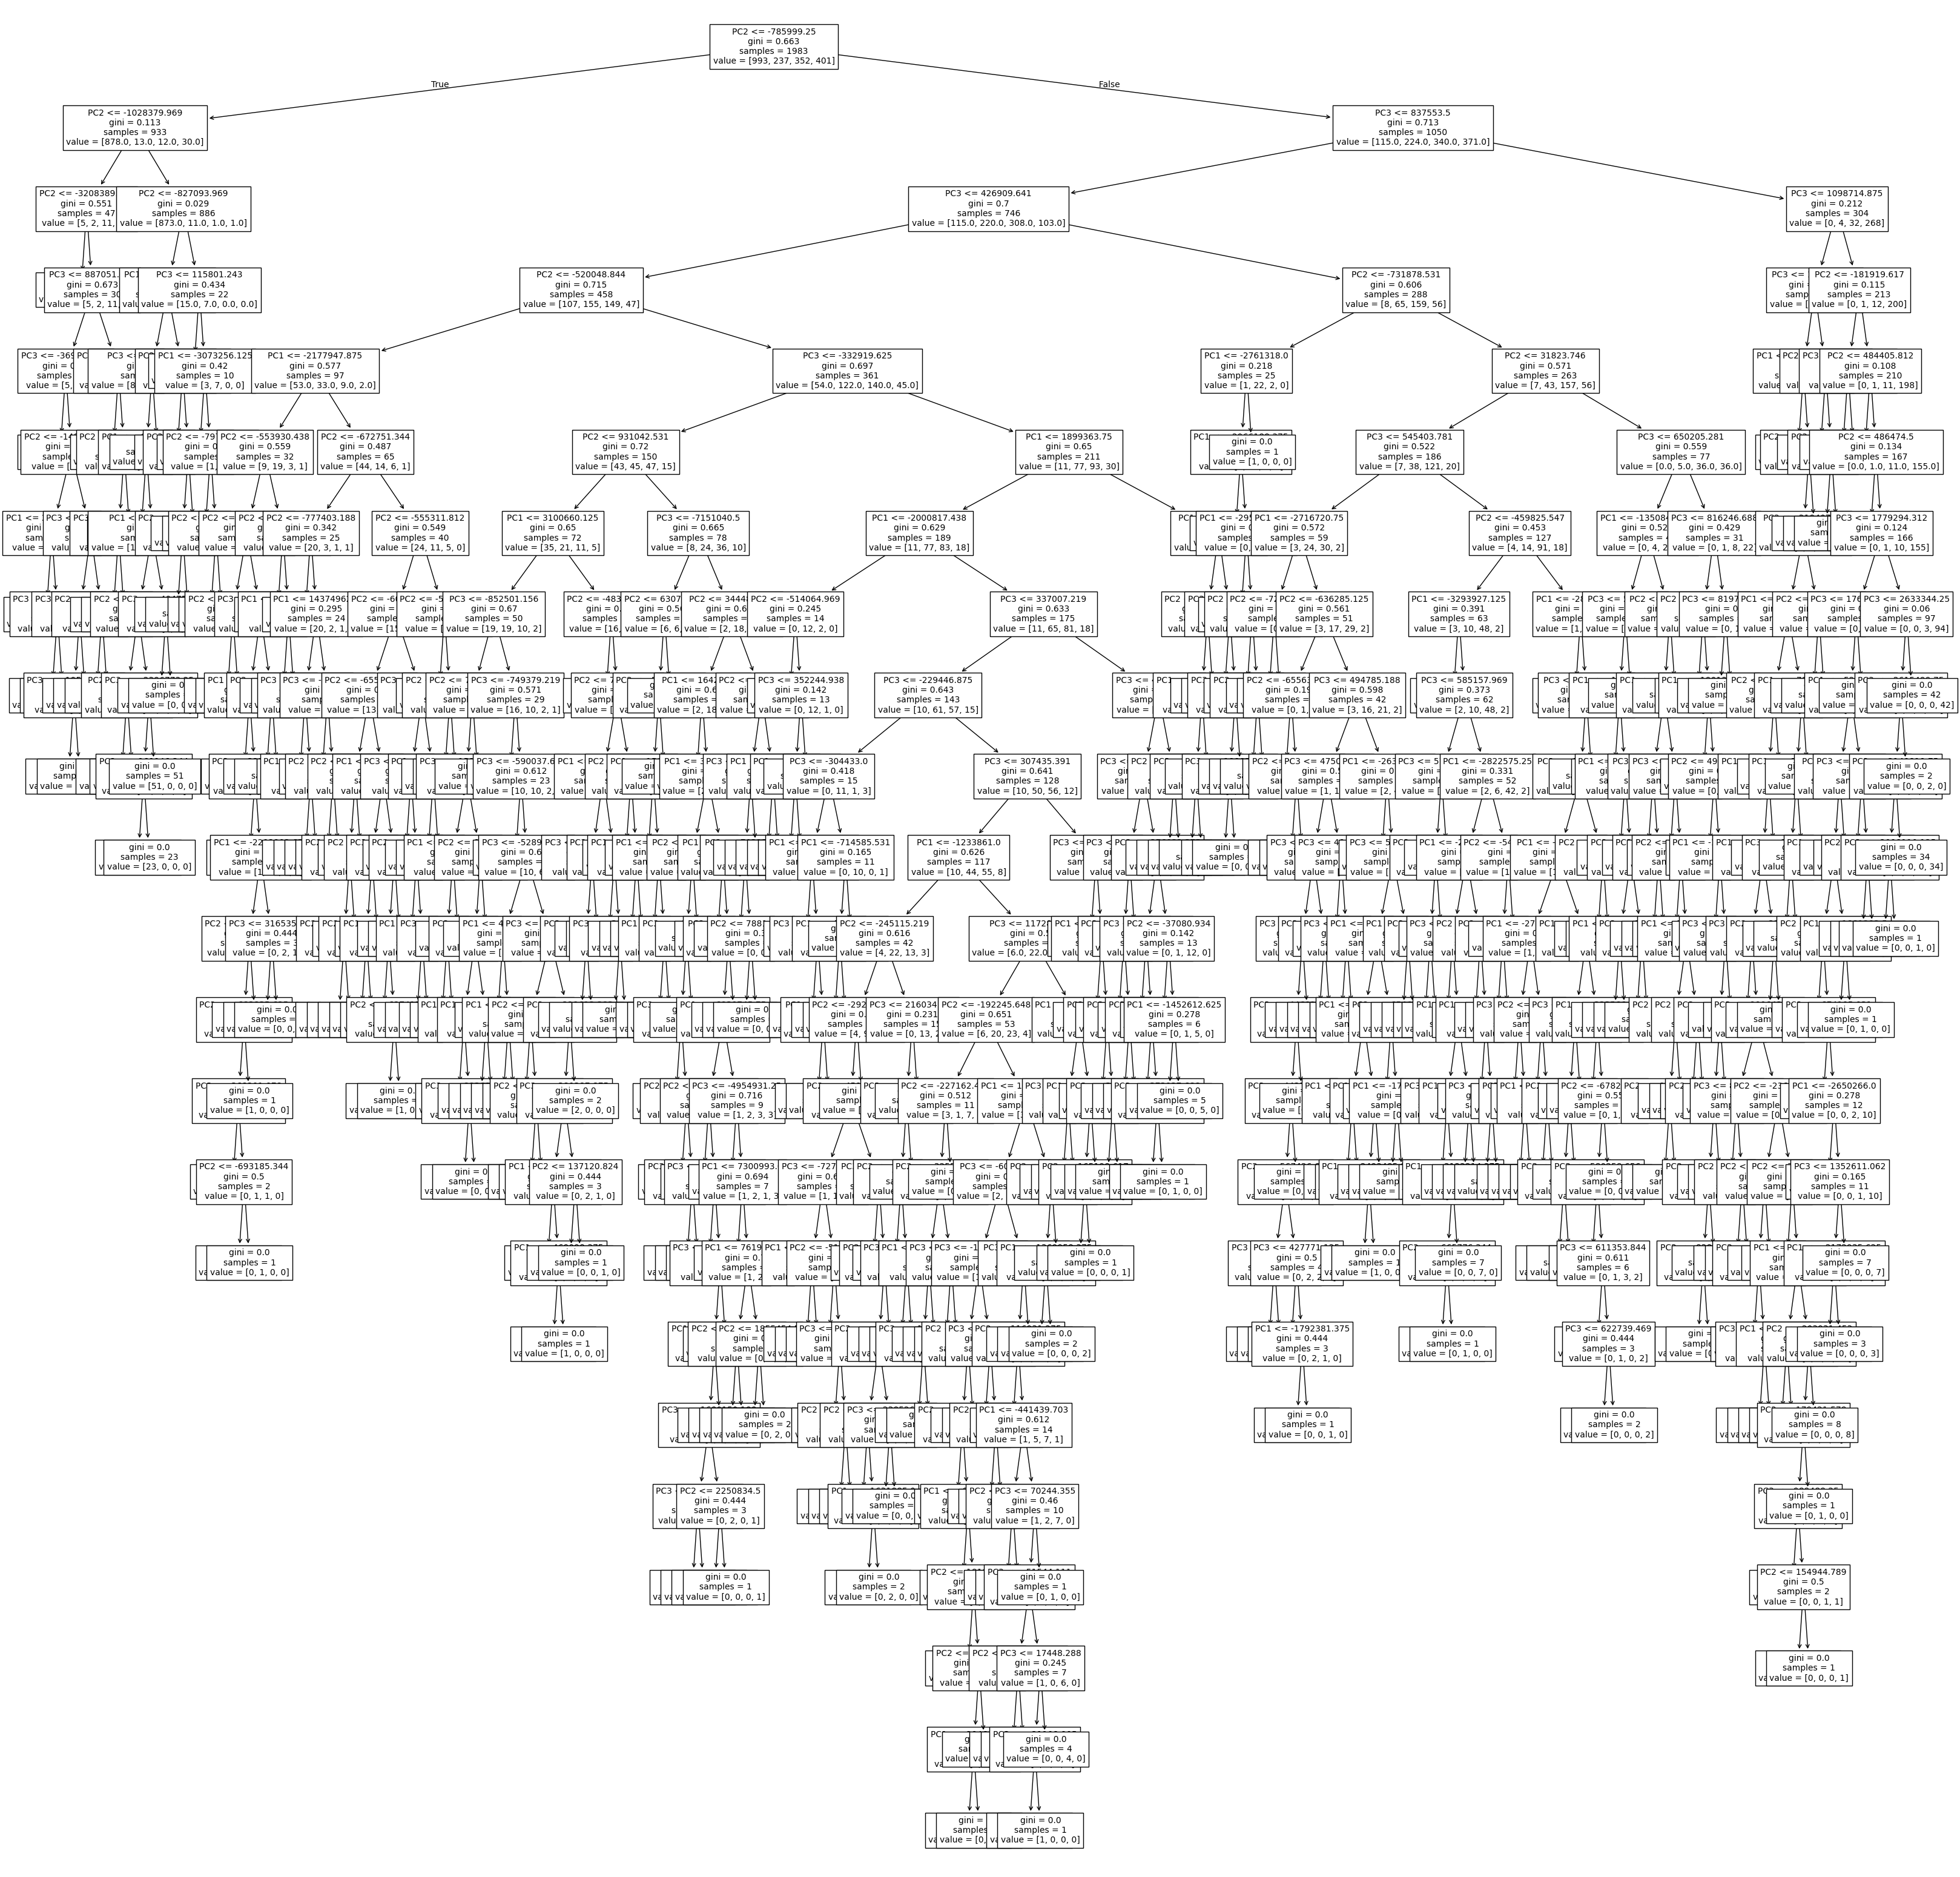

In [5]:
# -------- Tree with PCA components ---------

#Assigning the dependent and independent variables.
X = PCAdf[['PC1','PC2', 'PC3']]
y = PCAdf['GHGIntensityCluster']

#Splitting the data into training and testing sets. I chose a 80% training and 20% testing split. 
#random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
clf = DecisionTreeClassifier(random_state=12)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

#Printing accuracy findings of the model. 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Graphing the decision tree.
plt.figure(figsize=(40,40))
_ = tree.plot_tree(clf, feature_names = X.columns, fontsize=10)

In [ ]:
# -------- Tree with top 5 features from PC 1 ---------

data = pd.read_csv('Data/Seattle_Building_Clusters.csv')
data = data.drop(columns=['OSEBuildingID','BuildingName', 'BuildingType', 'Address', 'Neighborhood', 'EPAPropertyType', 'ComplianceStatus', 'ComplianceIssue', 'GHGEmissionsIntensity'])
data = data.dropna()

clusterData = data

#Assigning the dependent and independent variables.
#Not every variable is included in the independent variables, since some of them were strings and I didn't want to go to the trouble of changing types until we knew we liked this method.
X = clusterData[['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'PropertyGFATotal', 'SourceEUI(kBtu/sf)']]
y = clusterData[['GHGIntensityCluster']]

#Splitting the data into training and testing sets. I chose a 80% training and 20% testing split. 
#random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

param_grid = {
    'max_depth': [None, 10, 15, 20], #default is None
    'min_samples_split': [2, 5, 10, 15], #default is 2
    'min_samples_leaf': [1, 2, 5, 10, 15], #default is 1
    'max_leaf_nodes': [None, 5, 10, 15, 20], #default is None
    'ccp_alpha': [0, 0.01, 0.05, 0.1, 0.5] #default is 0
    
}
clf = DecisionTreeClassifier(random_state=12)
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs = -1, scoring = 'accuracy', )
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

#Printing accuracy findings of the model. 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Graphing the decision tree.
plt.figure(figsize=(40,40))
_ = tree.plot_tree(best_clf, feature_names = X.columns, fontsize=10)

## Results

The tree with PCA faired about the same as our original tree in exploratory analysis which used features 'YearBuilt','NumberofFloors','NumberofBuildings','PropertyGFATotal','ENERGYSTARScore','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)
with an accuracy of 74.5% However, when using the top 5 most influential features from PC 1 which are 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'PropertyGFATotal', 'SourceEUI(kBtu/sf)' the accuracy jumps up to 86.7% - quite the improvement.